### Frame the problem

Objective: Get a decent score on the Titanic dataset on Kaggle.

Performance measure: accuracy

Goal: obtain top 5% on Kaggle

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, \
                                recall_score, f1_score, PrecisionRecallDisplay, RocCurveDisplay
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

### Get the data

In [2]:
train_orig = pd.read_csv("titanic/train.csv")
test_orig = pd.read_csv("titanic/test.csv")
train = train_orig.copy()

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
test_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Explore the data

In [6]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
train.describe(include=['object'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [8]:
train["Ticket"].value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

In [9]:
train["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [10]:
train["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [11]:
train["NameLength"] = train["Name"].str.len()

In [12]:
corr_matrix = train.corr()
corr_matrix["Survived"].sort_values(ascending=False)

Survived       1.000000
NameLength     0.332350
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

array([[<AxesSubplot:xlabel='PassengerId', ylabel='PassengerId'>,
        <AxesSubplot:xlabel='Survived', ylabel='PassengerId'>,
        <AxesSubplot:xlabel='Pclass', ylabel='PassengerId'>,
        <AxesSubplot:xlabel='Age', ylabel='PassengerId'>,
        <AxesSubplot:xlabel='SibSp', ylabel='PassengerId'>,
        <AxesSubplot:xlabel='Parch', ylabel='PassengerId'>,
        <AxesSubplot:xlabel='Fare', ylabel='PassengerId'>,
        <AxesSubplot:xlabel='NameLength', ylabel='PassengerId'>],
       [<AxesSubplot:xlabel='PassengerId', ylabel='Survived'>,
        <AxesSubplot:xlabel='Survived', ylabel='Survived'>,
        <AxesSubplot:xlabel='Pclass', ylabel='Survived'>,
        <AxesSubplot:xlabel='Age', ylabel='Survived'>,
        <AxesSubplot:xlabel='SibSp', ylabel='Survived'>,
        <AxesSubplot:xlabel='Parch', ylabel='Survived'>,
        <AxesSubplot:xlabel='Fare', ylabel='Survived'>,
        <AxesSubplot:xlabel='NameLength', ylabel='Survived'>],
       [<AxesSubplot:xlabel='Passenger

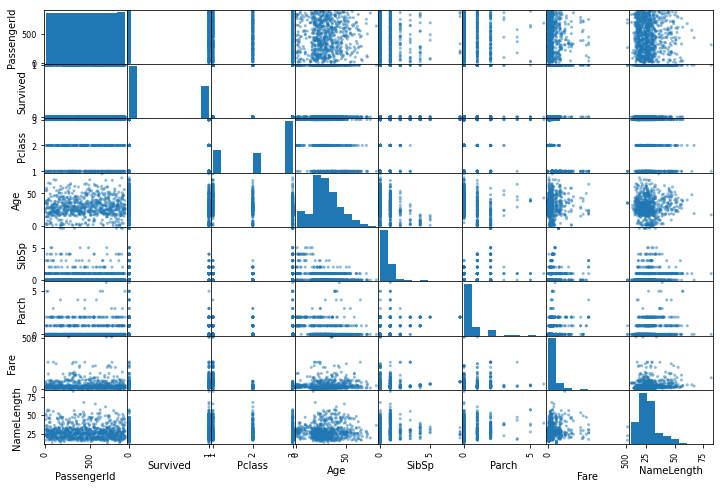

In [13]:
pd.plotting.scatter_matrix(train.select_dtypes(include=[np.number]), figsize=(12,8))

### Clean the data

In [14]:
train = train.drop("Survived", axis=1)
train_labels = train_orig["Survived"].copy()

In [15]:
train_num = train.select_dtypes(include=[np.number])
train_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Age          714 non-null    float64
 3   SibSp        891 non-null    int64  
 4   Parch        891 non-null    int64  
 5   Fare         891 non-null    float64
 6   NameLength   891 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 48.9 KB


In [16]:
train_cat = train.select_dtypes(include=['object'])
train_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Name      891 non-null    object
 1   Sex       891 non-null    object
 2   Ticket    891 non-null    object
 3   Cabin     204 non-null    object
 4   Embarked  889 non-null    object
dtypes: object(5)
memory usage: 34.9+ KB


In [17]:
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("std_scaler", StandardScaler()),
])

In [18]:
np_str_len = np.vectorize(len)

class StringLengthEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return np_str_len(X)
    
        

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("one_hot_encode", OneHotEncoder())
])


In [51]:
num_attributes = ['Age', 'SibSp', 'Parch', 'Fare']
cat_attributes = ["Pclass", "Sex", "Embarked"]
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attributes),
    # It seems like this field was allowing the RandomForestClassifier to overfit
    # to ~82% validation accuracy, but only 79% test set accuracy on Kaggle. 
    # Removing this reduced the validation accuracy of RandomForestClassifier to 79%, 
    # but boosted SVC to 82% validation set accuracy. 
    # ("name_length", StringLengthEncoder(), ["Name"]),
    ("one_hot_cat", cat_pipeline, cat_attributes),
])

In [52]:
train_prepared = full_pipeline.fit_transform(train_orig)
train_prepared[0]

array([-0.56573646,  0.43279337, -0.47367361, -0.50244517,  0.        ,
        0.        ,  1.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  1.        ])

### Shortlist promising models

/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


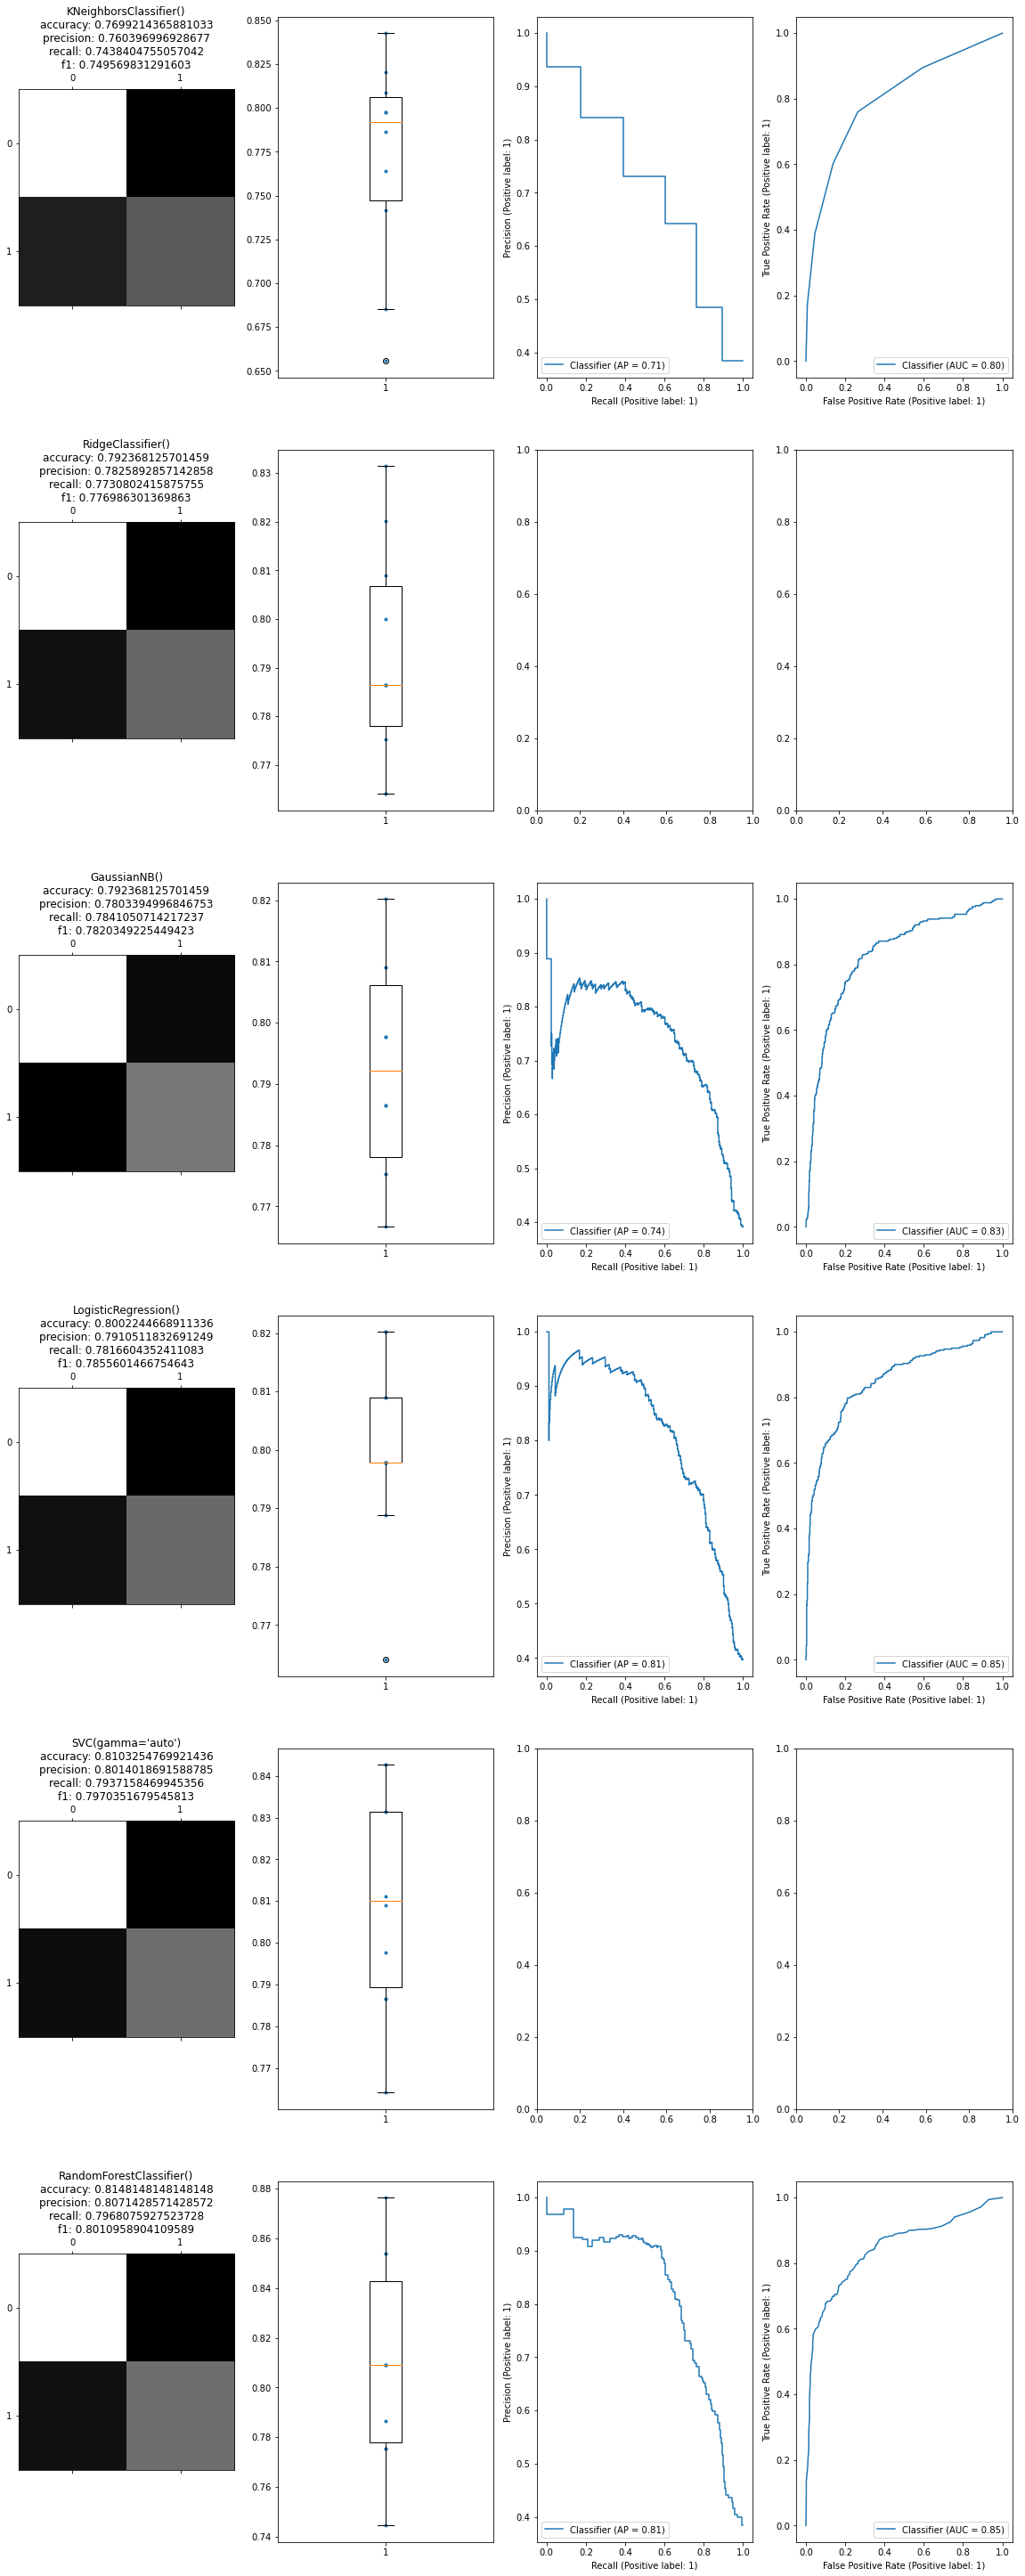

In [47]:
X_train_sample = train_prepared[:, :]
y_train_sample = train_labels[:]

models = [
    KNeighborsClassifier(), 
    RidgeClassifier(),
    GaussianNB(),
    LogisticRegression(),
    SVC(gamma="auto"), 
    RandomForestClassifier(), 
]

k_folds = 10

fig, axs = plt.subplots(len(models), 4, figsize=(20, 35))
plt.subplots_adjust(top=1.25)
for i, model in enumerate(models):
    y_train_pred = cross_val_predict(model, X_train_sample, y_train_sample, cv=k_folds)
    scores = cross_val_score(model, X_train_sample, y_train_sample, cv=k_folds)
    conf_mx = confusion_matrix(y_train_sample, y_train_pred)
    accuracy = accuracy_score(y_train_sample, y_train_pred)
    precision = precision_score(y_train_sample, y_train_pred, average="macro")
    recall = recall_score(y_train_sample, y_train_pred, average="macro")
    f1 = f1_score(y_train_sample, y_train_pred, average="macro")
    axs[i, 0].matshow(conf_mx, cmap=plt.cm.gray)
    axs[i, 0].set_title(f"{model}\naccuracy: {accuracy}\nprecision: {precision}\nrecall: {recall}\nf1: {f1}")
   
    # cross validation scores boxplot
    axs[i, 1].plot([1]*k_folds, scores, ".")
    axs[i, 1].boxplot([scores])
    
    if hasattr(model, "predict_proba"):
        y_train_pred_proba = cross_val_predict(model, X_train_sample, y_train_sample, cv=3, method="predict_proba")
        PrecisionRecallDisplay.from_predictions(y_train_sample, y_train_pred_proba[:, 1], ax=axs[i, 2])
        RocCurveDisplay.from_predictions(y_train_sample, y_train_pred_proba[:, 1], ax=axs[i, 3])
    
plt.show()

### Fine-tune model

In [53]:
param_distribs = {
    "n_estimators": list(range(1, 500)),
    "criterion": ["gini", "entropy"],
    "max_leaf_nodes": [2**i for i in range(1, 6)] + [None],
    "max_leaf_nodes": [2**i for i in range(1, 6)] + [None],
    "max_depth": [2**i for i in range(1, 6)] + [None],
}

rfc = RandomForestClassifier()
rnd_search = RandomizedSearchCV(
    rfc, 
    param_distributions=param_distribs,
    n_iter=1000,
    cv=10,
    scoring="accuracy",
    verbose=2,
    random_state=42,
    n_jobs=-1,
)
forest_search = rnd_search.fit(train_prepared, train_labels)
print(f"best estimator {forest_search.best_estimator_}\nbest score {forest_search.best_score_}")

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits
[CV] END ......................C=0.2, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END ......................C=0.4, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.8, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.8, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END ......................C=1.6, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ......................C=3.2, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ......................C=6.4, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END ......................C=6.4, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .....................C=25.6, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END .....................C=25.6, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END .......................C=0.2, degree=2, kernel=poly; total time=   0.0s
[CV] END .......................C=0.2, deg

[CV] END ......................C=0.2, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END ......................C=0.4, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END ......................C=0.8, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.8, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ......................C=1.6, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ......................C=3.2, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ......................C=6.4, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ......................C=6.4, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END .....................C=12.8, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END .....................C=12.8, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END .....................C=51.2, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END .....................C=51.2, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END ...................

[CV] END ......................C=0.2, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END ......................C=0.4, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.4, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END ......................C=0.8, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ......................C=1.6, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END ......................C=3.2, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END ......................C=6.4, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END ......................C=6.4, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END .....................C=25.6, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END .....................C=25.6, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END .......................C=0.2, degree=3, kernel=poly; total time=   0.0s
[CV] END .......................C=0.2, degree=3, kernel=poly; total time=   0.0s
[CV] END ...................

[CV] END ......................C=0.2, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.2, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.4, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.4, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END ......................C=0.8, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ......................C=1.6, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END ......................C=3.2, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END .....................C=12.8, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END .....................C=12.8, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END .....................C=25.6, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END .....................C=25.6, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END .......................C=0.2, degree=3, kernel=poly; total time=   0.0s
[CV] END ...................

[CV] END ......................C=0.2, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END ......................C=0.4, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.8, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ......................C=1.6, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ......................C=1.6, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ......................C=3.2, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ......................C=6.4, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END ......................C=6.4, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END .....................C=25.6, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END .....................C=25.6, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END .......................C=0.2, degree=2, kernel=poly; total time=   0.0s
[CV] END .......................C=0.2, degree=2, kernel=poly; total time=   0.0s
[CV] END ...................

[CV] END ......................C=0.2, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END ......................C=0.2, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END ......................C=0.4, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.8, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ......................C=1.6, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ......................C=3.2, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ......................C=6.4, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ......................C=6.4, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .....................C=12.8, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END .....................C=12.8, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END .....................C=51.2, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END .....................C=51.2, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END ...................

[CV] END ......................C=0.2, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END ......................C=0.4, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.8, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ......................C=1.6, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ......................C=1.6, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ......................C=3.2, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .....................C=12.8, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END .....................C=12.8, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END .....................C=25.6, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END .....................C=25.6, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END .......................C=0.2, degree=3, kernel=poly; total time=   0.0s
[CV] END .......................C=0.2, degree=3, kernel=poly; total time=   0.0s
[CV] END ...................

[CV] END ......................C=0.2, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END ......................C=0.4, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.8, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ......................C=1.6, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ......................C=3.2, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END ......................C=3.2, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ......................C=3.2, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .....................C=12.8, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END .....................C=12.8, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END .....................C=51.2, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END .....................C=51.2, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END .....................C=51.2, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END ...................

best estimator RandomForestClassifier(max_depth=8, n_estimators=181)
best score 0.8418102372034957


In [48]:
param_distribs = [
    {
        "C": [.1 * 2**i for i in range(1, 10)],
        "gamma": ["auto"],
        "kernel": ["rbf"],
    },
    {
        "C": [.1 * 2**i for i in range(1, 10)],
        "degree": [2, 3, 4],
        "kernel": ["poly"],
    },
    {
        "C": [.1 * 2**i for i in range(1, 10)],
        "kernel": ["linear"],
    },
    {
        "C": [.1 * 2**i for i in range(1, 10)],
        "kernel": ["sigmoid"],
    },
]

svc = SVC()
rnd_search = RandomizedSearchCV(
    svc, 
    param_distributions=param_distribs,
    n_iter=1000,
    cv=10,
    scoring="accuracy",
    verbose=2,
    random_state=42,
    n_jobs=-1,
)
search = rnd_search.fit(train_prepared, train_labels)
print(f"best estimator {search.best_estimator_}\nbest score {search.best_score_}")

Fitting 10 folds for each of 54 candidates, totalling 540 fits


/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 54 is smaller than n_iter=1000. Running 54 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


best estimator SVC(C=3.2, gamma='auto')
best score 0.818227215980025


In [54]:
test_prepared = full_pipeline.fit_transform(test_orig)
test_predictions = forest_search.best_estimator_.predict(test_prepared)

submission = pd.DataFrame({
    "PassengerId": test_orig.PassengerId, 'Survived': test_predictions,
})

submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [55]:
submission.to_csv("titanic/submission.csv", index=False)

[CV] END criterion=entropy, max_depth=8, max_leaf_nodes=8, n_estimators=444; total time=   1.3s
[CV] END criterion=entropy, max_depth=4, max_leaf_nodes=32, n_estimators=351; total time=   1.0s
[CV] END criterion=entropy, max_depth=4, max_leaf_nodes=2, n_estimators=149; total time=   0.4s
[CV] END criterion=gini, max_depth=4, max_leaf_nodes=2, n_estimators=162; total time=   0.4s
[CV] END criterion=gini, max_depth=4, max_leaf_nodes=2, n_estimators=162; total time=   0.5s
[CV] END criterion=entropy, max_depth=16, max_leaf_nodes=4, n_estimators=452; total time=   1.2s
[CV] END criterion=entropy, max_depth=8, max_leaf_nodes=None, n_estimators=188; total time=   0.6s
[CV] END criterion=entropy, max_depth=2, max_leaf_nodes=32, n_estimators=39; total time=   0.1s
[CV] END criterion=entropy, max_depth=2, max_leaf_nodes=32, n_estimators=39; total time=   0.1s
[CV] END criterion=entropy, max_depth=2, max_leaf_nodes=32, n_estimators=39; total time=   0.1s
[CV] END criterion=entropy, max_depth=2, 

[CV] END criterion=entropy, max_depth=16, max_leaf_nodes=2, n_estimators=427; total time=   1.3s
[CV] END criterion=gini, max_depth=32, max_leaf_nodes=8, n_estimators=279; total time=   0.8s
[CV] END criterion=gini, max_depth=32, max_leaf_nodes=8, n_estimators=279; total time=   0.8s
[CV] END criterion=entropy, max_depth=16, max_leaf_nodes=2, n_estimators=83; total time=   0.2s
[CV] END criterion=gini, max_depth=16, max_leaf_nodes=16, n_estimators=101; total time=   0.3s
[CV] END criterion=gini, max_depth=8, max_leaf_nodes=4, n_estimators=302; total time=   0.9s
[CV] END criterion=gini, max_depth=2, max_leaf_nodes=2, n_estimators=312; total time=   0.9s
[CV] END criterion=gini, max_depth=2, max_leaf_nodes=2, n_estimators=312; total time=   0.9s
[CV] END criterion=gini, max_depth=None, max_leaf_nodes=8, n_estimators=349; total time=   1.1s
[CV] END criterion=entropy, max_depth=4, max_leaf_nodes=4, n_estimators=408; total time=   1.2s
[CV] END criterion=gini, max_depth=4, max_leaf_nodes=

[CV] END criterion=gini, max_depth=8, max_leaf_nodes=None, n_estimators=23; total time=   0.1s
[CV] END criterion=gini, max_depth=2, max_leaf_nodes=4, n_estimators=398; total time=   1.2s
[CV] END criterion=entropy, max_depth=16, max_leaf_nodes=2, n_estimators=427; total time=   1.2s
[CV] END criterion=entropy, max_depth=2, max_leaf_nodes=16, n_estimators=334; total time=   1.0s
[CV] END criterion=entropy, max_depth=2, max_leaf_nodes=16, n_estimators=334; total time=   1.0s
[CV] END criterion=gini, max_depth=32, max_leaf_nodes=8, n_estimators=279; total time=   0.9s
[CV] END criterion=entropy, max_depth=16, max_leaf_nodes=2, n_estimators=83; total time=   0.2s
[CV] END criterion=gini, max_depth=16, max_leaf_nodes=16, n_estimators=101; total time=   0.3s
[CV] END criterion=gini, max_depth=16, max_leaf_nodes=16, n_estimators=101; total time=   0.3s
[CV] END criterion=gini, max_depth=8, max_leaf_nodes=4, n_estimators=302; total time=   0.9s
[CV] END criterion=gini, max_depth=2, max_leaf_n

[CV] END criterion=gini, max_depth=None, max_leaf_nodes=None, n_estimators=93; total time=   0.3s
[CV] END criterion=entropy, max_depth=4, max_leaf_nodes=None, n_estimators=424; total time=   1.2s
[CV] END criterion=entropy, max_depth=None, max_leaf_nodes=8, n_estimators=215; total time=   0.6s
[CV] END criterion=entropy, max_depth=None, max_leaf_nodes=8, n_estimators=215; total time=   0.6s
[CV] END criterion=entropy, max_depth=None, max_leaf_nodes=8, n_estimators=450; total time=   1.3s
[CV] END criterion=gini, max_depth=2, max_leaf_nodes=16, n_estimators=416; total time=   1.1s
[CV] END criterion=gini, max_depth=None, max_leaf_nodes=16, n_estimators=11; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_leaf_nodes=2, n_estimators=356; total time=   1.0s
[CV] END criterion=gini, max_depth=4, max_leaf_nodes=16, n_estimators=387; total time=   1.1s
[CV] END criterion=gini, max_depth=4, max_leaf_nodes=16, n_estimators=387; total time=   1.1s
[CV] END criterion=entropy, max_

### Evaluate performance on test set

Scored .79186 accuracy on Kaggle. Position 881 on leaderboard, which is top %6.3. This wasn't quite the goal of top 5%. I'll come back and try to improve on this score.